In [1]:
%load_ext autoreload
%autoreload 2

import os, torch, click, numpy as np
import datetime

import swyft
from utils import *
from plot import *

from tqdm import tqdm
from data_mgmt import get_paths, get_ids
import pickle




DEVICE = 'cuda'


from torch import tensor

imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower') #left, right, bottom, top

import matplotlib.colors
from IPython.display import HTML
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams.update({'font.size': 15})



In [2]:




m = 1
nsub = 3
nsim = 10000
nmc = 1
npred = 0 #nsim
sigmas = [0.0, 0.1, 0.5, 1.0, 2.0, 100.0] 
# sigmas = [0.0]
zero = 'toy'

entries = []
for sigma in sigmas:
    entry = dict(m=m,nsub=nsub,nsim=nsim,nmc=nmc,sigma=sigma,npred=npred,zero='toy')
    entries.append(entry)
    
    print(entry)
entries = np.array(entries)
n_entries = len(entries)

{'m': 1, 'nsub': 3, 'nsim': 10000, 'nmc': 1, 'sigma': 0.0, 'npred': 0, 'zero': 'toy'}
{'m': 1, 'nsub': 3, 'nsim': 10000, 'nmc': 1, 'sigma': 0.1, 'npred': 0, 'zero': 'toy'}
{'m': 1, 'nsub': 3, 'nsim': 10000, 'nmc': 1, 'sigma': 0.5, 'npred': 0, 'zero': 'toy'}
{'m': 1, 'nsub': 3, 'nsim': 10000, 'nmc': 1, 'sigma': 1.0, 'npred': 0, 'zero': 'toy'}
{'m': 1, 'nsub': 3, 'nsim': 10000, 'nmc': 1, 'sigma': 2.0, 'npred': 0, 'zero': 'toy'}
{'m': 1, 'nsub': 3, 'nsim': 10000, 'nmc': 1, 'sigma': 100.0, 'npred': 0, 'zero': 'toy'}


In [3]:
def get_pred(entry):
    _, _, _, pred_path = get_paths(entry)
    
    with open(pred_path, 'rb') as f:
        pred = pickle.load(f)
        
    posts, targets, obs0s, v0s, obs0_is = list(pred.values())
    return posts, targets, obs0s, v0s, obs0_is

posts_all = []
targets_all = []
obs0s_all = []
v0s_all = []
obs0_is_all = []

for entry in entries:
    posts, targets, obs0s, v0s, obs0_is = get_pred(entry)
    
    posts_all.append(posts)
    targets_all.append(targets)
    obs0s_all.append(obs0s)
    v0s_all.append(v0s)
    obs0_is_all.append(obs0_is)
    

In [4]:
def get_f(posts, targets, x):
    
    x1, x2 = x[:-1], x[1:]
    
    
    def f3(xi, xj):
        y = targets[(posts > xi) & (posts <= xj)]
        return y.sum() / len(y) if y.sum() != 0 else 0

    return np.array([f3(xi, xj) for xi, xj in zip(x1, x2)])

# def get_f(posts, targets, x):
    
#     x1, x2 = x[:-1], x[1:]
    
#     def f1(xi):
#         y = targets[posts > xi]
#         return y.sum() / len(y) if y.sum() != 0 else 0
        
#     def f2(xi, xj):
#         y = targets[(posts > xi) & (posts <= xj)]
#         return y.sum() / len(y) if y.sum() != 0 else 0
    
#     def f3(xj):
#         y = targets[posts <= xj]
#         return y.sum() / len(y) if y.sum() != 0 else 0
    
#     ret1 = np.array([f1(xi) for xi in zip(x1)])
#     ret2 = np.array([f2(xi, xj) for xi, xj in zip(x1, x2)])
#     ret3 = np.array([f3(xj) for xj in zip(x2)])

#     return ret1, ret2, ret3

In [5]:
# alpha_edges_full = np.array([np.full(posts.shape, a) for a in alpha_edges])
# posts_full = np.array([posts]*(n_alpha-1))
# targets_full = np.array([targets]*(n_alpha-1))

# y = np.where((posts_full > alpha_edges_full[:-1]) & (posts_full < alpha_edges_full[1:]), 1, 0)
# y2 = np.equal(targets_full, y)
# y3 = np.sum(y2, axis = (1, 2, 3, 4)) 
# y4 = y3 / np.prod(y.shape[1:])

In [6]:
def get_tc(i, v0, target):
    y, x, m = v0.reshape(-1, 3).T
#     m_i = np.where(target == 1)[0]
#     target_coords = np.array((m_i, x, y)).T
    
    m_i = np.full(len(x), i)
    target_coords = np.array((m_i, x, y)).T

    return target_coords

def get_target_coords(i, v0s):
    return np.concatenate([get_tc(j, v0s[j], targets[j]) for j in range(i)])

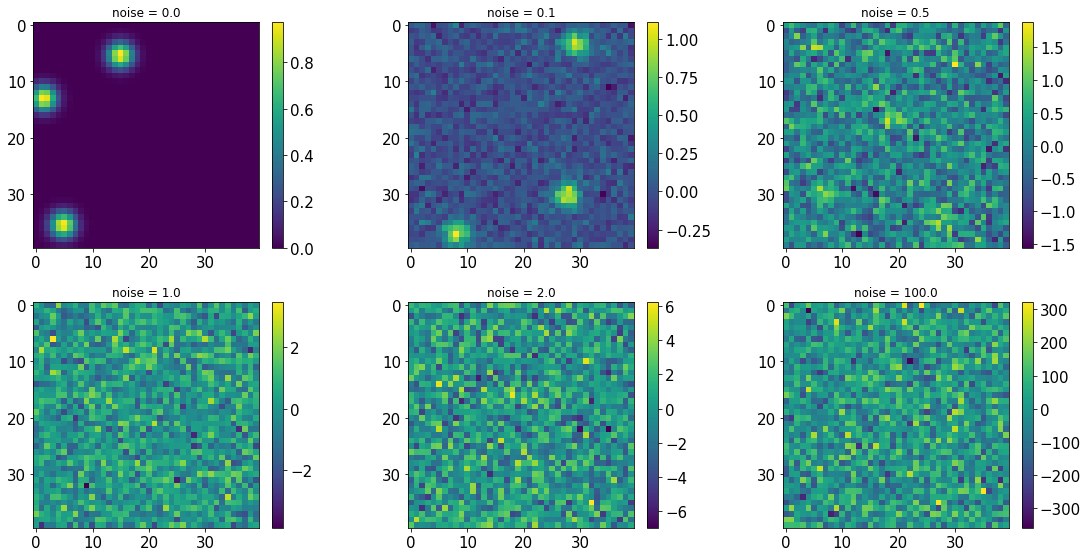

In [7]:
plt_imshow( np.array([obs0s[0] for obs0s in obs0s_all]),
           nrows = 2,
           titles = [f"noise = {entry['sigma']}" for entry in entries], 
           cbar = True, tl = True )

In [8]:

for entry in entries:
    posts, targets, obs0s, v0s, obs0_is = get_pred(entry)
    
    l = 4
    
#     plt_imshow( obs0s[:l], target_coords = get_target_coords(l, v0s), **imkwargs, cbar = True)
#     plt_imshow( posts.squeeze()[:l], target_coords = get_target_coords(l, v0s), **imkwargs, cbar = True)


In [9]:
def temp_prior(entries):
    L = 40
    priors =  [entry['nsub'] / (L*L) / entry['nmc']  for entry in entries]
    assert all([prior == priors[0] for prior in priors])
    return priors[0]
        
prior_freq = temp_prior(entries)

In [10]:
n_alpha = 10
alpha_edges = np.linspace(0, 1, n_alpha)
alpha_centers = (alpha_edges[:-1] + alpha_edges[1:])/2

In [11]:
fs = np.array([get_f(posts, targets, alpha_edges) for posts, targets in zip(posts_all, targets_all)])

# ff = np.array([get_f(posts, targets, alpha_edges) for posts, targets in zip(posts_all, targets_all)])
# ff = np.transpose(ff, (1, 0, 2))

In [17]:
f = fs[2]
posts = posts_all[2]
targets = targets_all[2]

In [ ]:
for _ in range(1000):
    i = np.random.randint(9817)
    x, y, = np.random.randint(40), np.random.randint(40)
    if posts[i,0,x,y] > 0.1:
        print( posts[i,0,x,y], posts2[i,0,x,y] )

In [ ]:
a = np.array([0.11, 0.22, 0.33, 0.44, 0.55, 0.66, 0.77, 0.88])
ac = np.array([0.22, 0.75])
ae = np.array([0.0, 0.5, 1.0])

a2 = np.zeros(len(a))

for xi, xj, xc in zip(ae[:-1], ae[1:], ac):
    a2 = np.where((a > xi) & (a < xj), xc, a2)

In [21]:
posts2 = np.copy(posts)

In [26]:
posts2.shape

(9817, 1, 40, 40)

In [24]:
np.full(*posts2.shape, f)

TypeError: full() takes from 2 to 4 positional arguments but 5 were given

In [28]:
for xi, xj, xc in zip(alpha_edges[:-1], alpha_edges[1:], f):
    print(xc)
    posts2 = np.where((posts > xi) & (posts < xj), xc, posts2)

0.000404792507663333
0.14199120091249795
0.2117045654856337
0.2745193477731808
0.33727020642908495
0.38707289996299493
0.4516676961087091
0.4807692307692308
0.512568306010929


In [29]:
# f1 = get_f(posts, targets, alpha_edges)
f_new = get_f(posts2, targets, alpha_edges)

In [32]:
f_new

array([4.04792508e-04, 1.66862318e-01, 2.74519348e-01, 3.59896884e-01,
       4.66847209e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

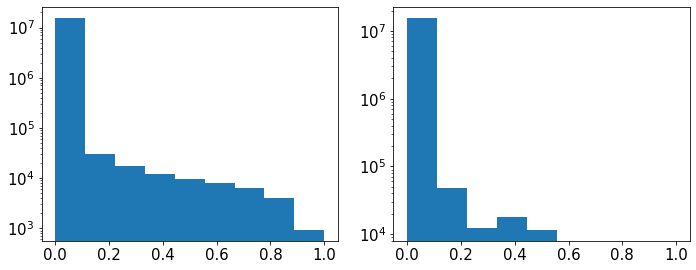

In [30]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4), tight_layout = True)

for ax, p in zip(axs, [posts, posts2]):
    ax.hist(p.flatten(), bins = alpha_edges)
    ax.set_yscale('log')

    


plt.show()

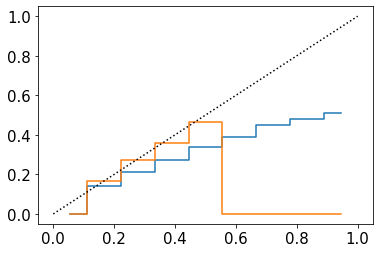

In [34]:
plt.step(alpha_centers, f, where='mid')
# plt.show()
plt.step(alpha_centers, f_new, where='mid')
plt.plot([0, 1], [0, 1], "k:")


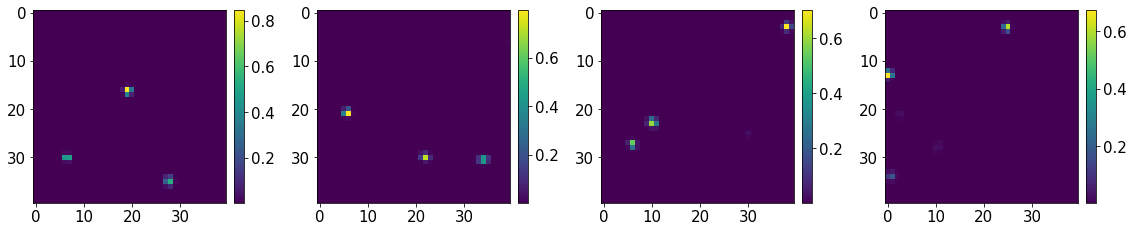

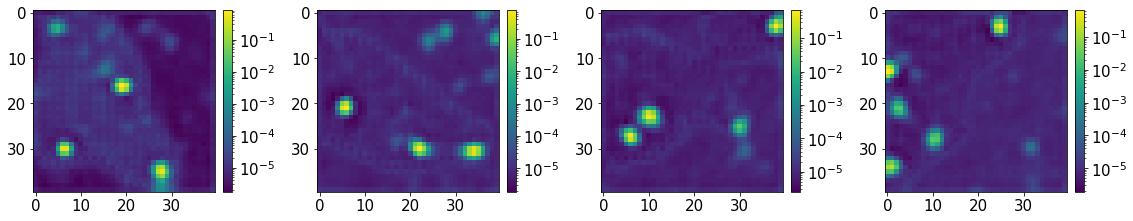

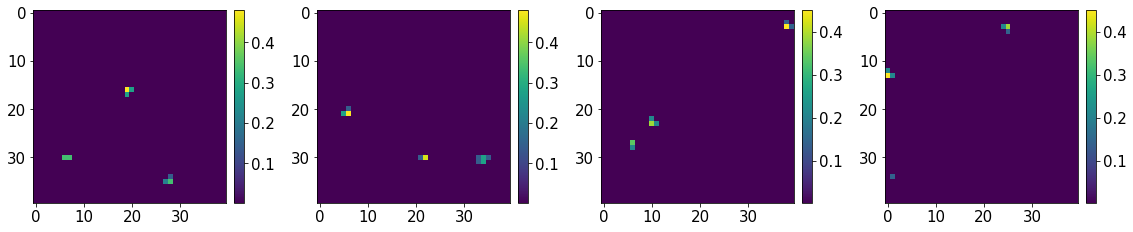

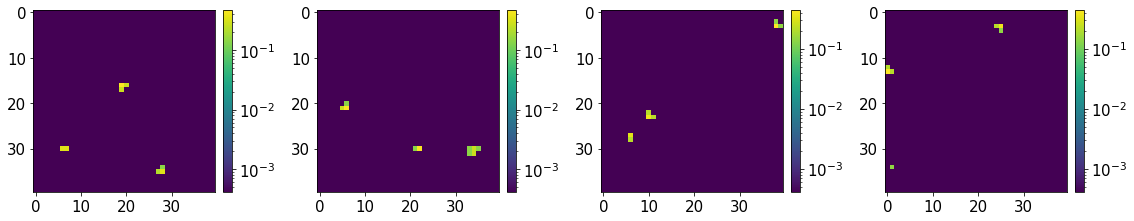

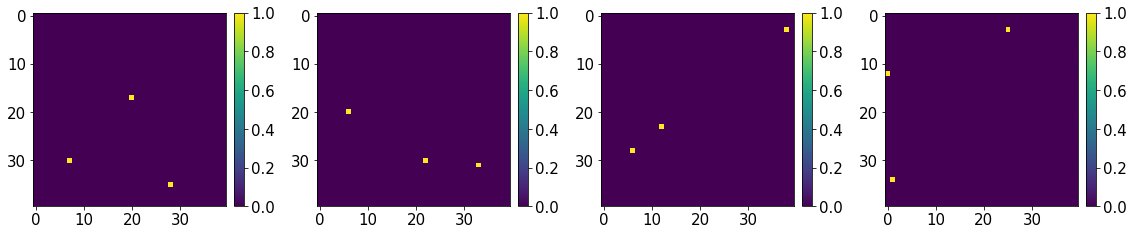

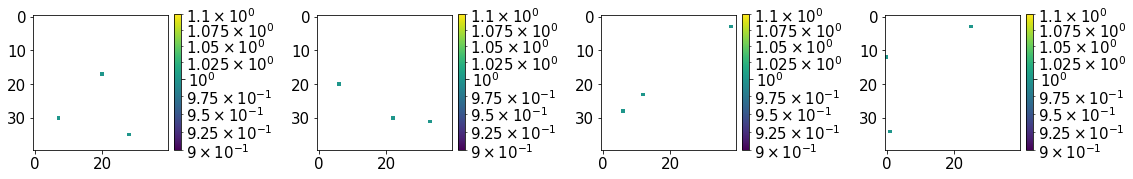

In [35]:
plots = [posts, posts2, targets]

for plot in plots:
    plt_imshow( plot[:4].squeeze(), cbar = True, tl = True)
    plt_imshow( plot[:4].squeeze(), cbar = True, tl = True, zlog = True)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (20, 6), tight_layout = True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
titles = [r'$p(1|x)>\alpha$', r'$\alpha<p(1|x)<\alpha$', r'$p(1|x)<\alpha$']


for ax, fs, alpha, title in zip(axs, ff, [alpha_edges[:-1], alpha_centers, alpha_edges[1:]], titles):
    for f, entry, color in zip(fs, entries, colors):
        ax.step(alpha, f, label = f"{entry['sigma']}", where='mid', color = color)
#     ax.plot([0, 1], [0, 1], "k:")
    # ax.plot([0, 1], [prior_freq, prior_freq], "k--")
    ax.set_xlabel(r'Predicted $p(1|x)$')
    ax.set_ylabel(r'Measured fraction $p(1|x)$')
    ax.set_title(title)
#     ax.set_title(rf'$N_{{sub}} = {nsub}$, noise = {sigma}, {zero} model')
ax.legend(title = 'noise')

plt.show()

In [ ]:
from scipy import interpolate
from scipy import stats

In [ ]:
f = interpolate.interp1d(quantiles, matching_discrete_cdf, kind='linear')
uni_rv = stats.uniform.rvs(loc=percentiles.min(), 
         scale=percentiles.max() - percentiles.min(), size=nof_items)
pdf = f(uni_rv)

In [ ]:
plt.plot(xx)

In [ ]:
fs = ff[1]

In [ ]:
fsc = np.cumsum(fs, axis = 1)

In [ ]:
plt.step(alpha_centers, fsc.T / np.max(fsc, axis = 1), where = 'mid')

In [ ]:
fsc[:,-1]

In [ ]:
plt.plot(fsc.T)

In [ ]:
np.sum(fsc, axis = 1)

In [ ]:
plt.plot(alpha_centers, fsc[1])

In [ ]:
assert 1 === 2

In [ ]:
fs = np.array([get_f(posts, targets, alpha_edges) for posts, targets in zip(posts_all, targets_all)])

In [ ]:
fig, axs = plt.subplots(1, 1, figsize = (8, 6), tight_layout = True)

ax = axs

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for f, entry, color in zip(fs, entries, colors):
    ax.step(alpha_centers, f, label = f"{entry['sigma']}", where='mid', color = color)
    print(color)
ax.plot([0, 1], [0, 1], "k:")
# ax.plot([0, 1], [prior_freq, prior_freq], "k--")
ax.set_xlabel(r'Predicted $p(1|x)$')
ax.set_ylabel(r'Measured fraction $p(1|x)$')
ax.set_title(rf'$N_{{sub}} = {nsub}$, $N_{{sim}} = {nsim}$, {zero} model')
ax.legend(title = r'noise')

plt.show()

In [ ]:
prior_freq

In [ ]:
fig, axs = plt.subplots(1, n_entries, figsize = (20, 4), tight_layout = True)

    
for ax, posts, entry, color in zip(axs[:-1], posts_all, entries, colors):
    ax.hist(posts.flatten(), bins = alpha_edges, color = color)
    ax.set_yscale('log')
    ax.set_xlabel(r'$p(1|x)$')
    ax.set_ylabel(r'$N$')
    ax.set_title(f"noise = {entry['sigma']}")
    

for ax, entry, posts, color in zip(axs[-1:], entries[-1:], posts_all[-1:], colors[5:6]):
    h, _, _  = ax.hist(posts[:10].flatten(), color = color)
    ax.set_xlabel(r'$p(1|x)$')
    ax.set_ylabel(r'$N$')
    ax.set_title(rf"noise = {entry['sigma']}")
    ax.axvline(x = prior_freq, ymin = 0, ymax = max(h))


plt.show()